# CI Analysis of data from Schweppe Lab

In [113]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

import pyro
from indra_cogex.client import Neo4jClient

from y0.algorithm.identify import Identification, identify
from y0.dsl import Variable, P

from MScausality.graph_construction.single_node import build_network
from MScausality.causal_model.LVM import LVM

import statsmodels.formula.api as smf

## Input data

In [168]:
raw_data = pd.read_csv("../../data/Schweppe/Belinostat_all_norm.csv")

In [169]:
raw_data.head()

,Uniprot,Gene,Rep1_norm2,Rep2_norm2,Rep3_norm2,Drug,Line
0,A0A0B4J2F0,PIGBOS1,1.898835,2.137074,2.560931,DMSO,A549
1,A0A0C4DH34,IGHV4-28,0.540362,0.590821,0.494499,DMSO,A549
2,A0A0U1RRE5,NBDY,0.121079,0.126981,0.132406,DMSO,A549
3,A0A1B0GUW7,SMIM27,1.580457,1.580457,1.580457,DMSO,A549
4,A0AV96,RBM47,1.256145,1.378258,1.306203,DMSO,A549


### Data is a mess and needs to be cleaned up.

#### Missing values

There are no missing values bc bad data processing. We can figure out which
were trash imputation by looking at rows with the same value for all reps.

In [170]:
raw_data.loc[np.isnan(raw_data["Rep1_norm2"]) | 
             np.isnan(raw_data["Rep2_norm2"]) | 
             np.isnan(raw_data["Rep3_norm2"])]

,Uniprot,Gene,Rep1_norm2,Rep2_norm2,Rep3_norm2,Drug,Line


In [171]:
missing = raw_data.loc[(raw_data["Rep1_norm2"] ==  raw_data["Rep2_norm2"]) &
             (raw_data["Rep1_norm2"] ==  raw_data["Rep3_norm2"]) & 
             (raw_data["Rep3_norm2"] ==  raw_data["Rep2_norm2"])]
missing.head()

,Uniprot,Gene,Rep1_norm2,Rep2_norm2,Rep3_norm2,Drug,Line
3,A0A1B0GUW7,SMIM27,1.580457,1.580457,1.580457,DMSO,A549
6,A0AVI4,TMEM129,1.346898,1.346898,1.346898,DMSO,A549
24,A2RUB1,MEIOC,1.109583,1.109583,1.109583,DMSO,A549
32,A4D1S0,KLRG2,1.968892,1.968892,1.968892,DMSO,A549
35,A5PL33,KRBA1,0.964452,0.964452,0.964452,DMSO,A549


In [172]:
len(missing) / len(raw_data)

0.038886697125112946

About 4% of rows have equal values. It is not clear what to do with these atm. 
Test both with and without these and look at correlations.

#### Big Values

In [173]:
long_df = pd.melt(raw_data, id_vars = ['Uniprot', 'Gene', 'Drug', 'Line'], 
        value_vars = ['Rep1_norm2', 'Rep2_norm2', 'Rep3_norm2'], 
        value_name = 'Intensity', var_name="replicate")

There are some really high values. These are probably caused by bad data 
processing. Treat as unreliable. Determine cutoff by looking at 99th quantile.

In [174]:
long_df["Intensity"].quantile(.99)

8.464314697332822

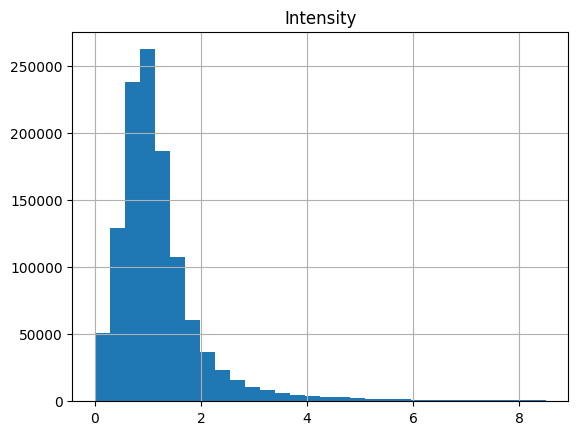

In [175]:
long_df.loc[long_df["Intensity"] < 8.5].hist(bins=30)
long_df = long_df[long_df["Intensity"] < 8.5]

In [176]:
long_df.loc[:, "Intensity"] = np.log2(long_df.loc[:, "Intensity"])

<Axes: >

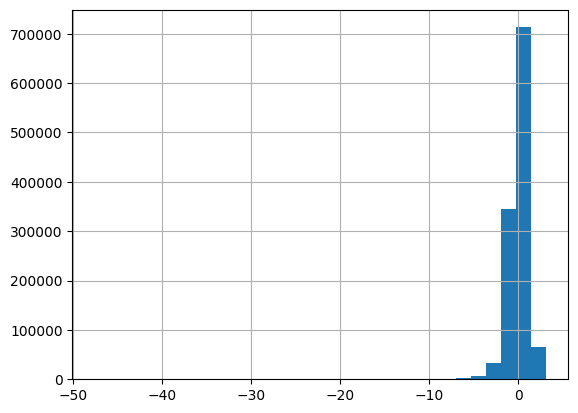

In [177]:
long_df.loc[:, "Intensity"].hist(bins=30)

### Toss data into wide format

In [178]:
long_df.loc[:, "Replicate"] = long_df.loc[:, "Drug"] + "_" + long_df.loc[:, "Line"]+ "_" + long_df.loc[:, "replicate"]
len(long_df.loc[:, "Replicate"].unique())

long_df = long_df.groupby(["Gene", "Replicate"])["Intensity"].mean().reset_index()
input_data = long_df.pivot(index="Replicate", columns="Gene", values="Intensity")

144

## Build Graph

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

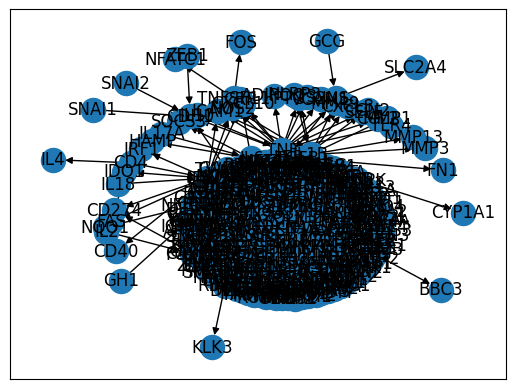

In [258]:
client = Neo4jClient(url=os.getenv("API_URL"), 
                    auth=(os.getenv("USER"), 
                        os.getenv("PASSWORD"))
                )

network = build_network(["CDKN1A"], "gene", client,
                        evidence_count=[5, 150, 150], levels=3,
                        upstream=True, downstream=True)


graph = nx.DiGraph()
for i in range(len(network)):
    graph.add_edge(network.loc[i, "source_hgnc_symbol"], 
                    network.loc[i, "target_hgnc_symbol"])
pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
nx.draw_networkx(graph, pos)

plt.show()

network.reset_index(drop=True).to_csv(
        "../../data/INDRA_networks/schweppe_networks/cdkn1a_model.tsv",
        sep="\t",
        index=False)

In [259]:
long_df = long_df.rename(columns={"Gene": "Protein",
                                  "Replicate": "Run",
                                  "Intensity": "Abundance"})
train_data = long_df.loc[long_df["Run"].str.contains("DMSO")]

In [260]:
train_data.head()

,Protein,Run,Abundance,Condition,Cell_line
14,A1BG,DMSO_A549_Rep1_norm2,1.578647,DMSO,A549
15,A1BG,DMSO_A549_Rep3_norm2,1.158121,DMSO,A549
16,A1BG,DMSO_H1915_Rep1_norm2,0.840398,DMSO,H1915
17,A1BG,DMSO_H1915_Rep2_norm2,0.807203,DMSO,H1915
18,A1BG,DMSO_H1915_Rep3_norm2,0.862533,DMSO,H1915


Preparing experimental data...
Preparing INDRA statements...
Building graph...
Fixing cycles...


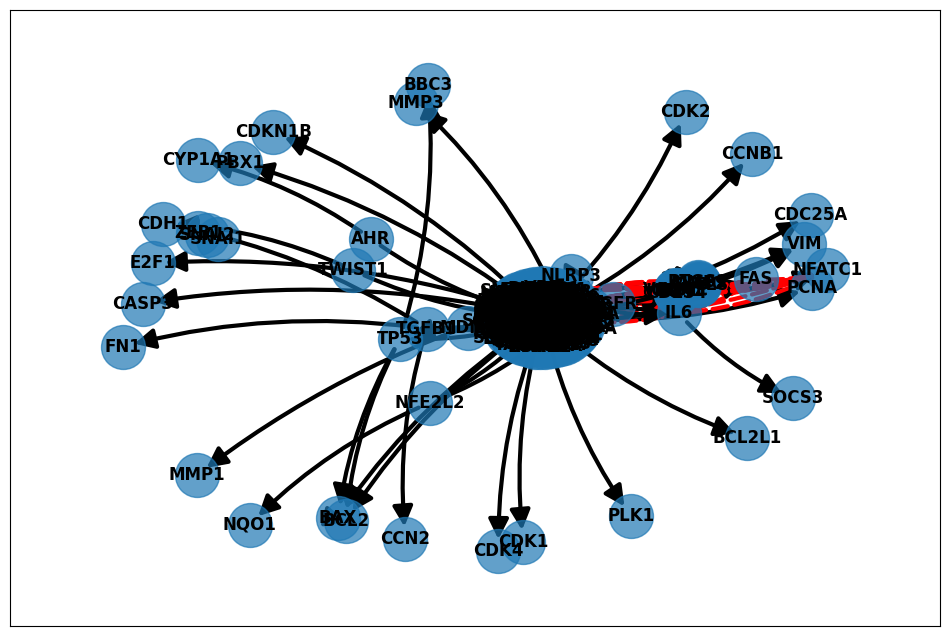

In [261]:
from MScausality.graph_construction.graph import GraphBuilder

example_graph = GraphBuilder(network, 
                                train_data, 
                                True) # MSstats format or not

example_graph.build_full_graph(data_type="LF", # LF (label free) or TMT
                        protein_format="Gene_Name_Organism", # How the proteins are named in the data
                        source_name="source_hgnc_symbol",
                        target_name="target_hgnc_symbol")
example_graph.build_dag() # TODO: Right now removing cycles can take forever on long graphs. Need a better optimized algo for this.
example_graph.create_latent_graph()
example_graph.plot_latent_graph(figure_size=(12, 8))

In [215]:
[i for i in list(example_graph.causal_graph.directed.edges) if Variable("CDKN1A") in i]

[(ATM, CDKN1A),
 (PPARG, CDKN1A),
 (ZBTB17, CDKN1A),
 (PRMT6, CDKN1A),
 (DHPS, CDKN1A),
 (ZNF385A, CDKN1A),
 (PML, CDKN1A),
 (SMARCB1, CDKN1A),
 (BIRC5, CDKN1A),
 (CDKN2A, CDKN1A),
 (FOXO3, CDKN1A),
 (SOX2, CDKN1A),
 (ID1, CDKN1A),
 (TBX2, CDKN1A),
 (STAT3, CDKN1A),
 (SMARCA4, CDKN1A),
 (PPP1R15A, CDKN1A),
 (SKP2, CDKN1A),
 (SMAD3, CDKN1A),
 (FOXG1, CDKN1A),
 (TP53, CDKN1A),
 (ACTL6A, CDKN1A),
 (HGF, CDKN1A),
 (NOTCH1, CDKN1A),
 (FOXO1, CDKN1A),
 (RB1, CDKN1A),
 (LRRK2, CDKN1A),
 (DCN, CDKN1A),
 (METTL3, CDKN1A),
 (HDAC2, CDKN1A),
 (CDKN1A, BAX),
 (CDKN1A, BCL2),
 (CDKN1A, CASP3),
 (CDKN1A, CCNB1),
 (CDKN1A, CDK1),
 (CDKN1A, CDK2),
 (CDKN1A, CDK4),
 (CDKN1A, CDKN1B),
 (CDKN1A, E2F1),
 (CDKN1A, NFE2L2),
 (CDKN1A, PLK1),
 (MYC, CDKN1A),
 (NFIC, CDKN1A),
 (SMAD4, CDKN1A),
 (PTK2, CDKN1A),
 (EGF, CDKN1A),
 (EP300, CDKN1A),
 (HDAC4, CDKN1A),
 (MKRN1, CDKN1A),
 (STK11, CDKN1A),
 (TAF9, CDKN1A),
 (KDM1A, CDKN1A),
 (BCL11B, CDKN1A),
 (KLF2, CDKN1A),
 (CTNNB1, CDKN1A),
 (ZBTB7A, CDKN1A),
 (NOTC

In [262]:
pyro.clear_param_store()
lvm = LVM(example_graph.experimental_data.reset_index(drop=True), 
          example_graph.causal_graph)
lvm.prepare_graph()
lvm.prepare_data()

lvm.fit_model(num_steps=5000)
#lvm.intervention("obs_Ras", "Erk", 3.)

Step 0: Loss = 79960.93694542965
Step 100: Loss = 24230.720348543487
Step 200: Loss = 11515.225603163242
Step 300: Loss = 6177.418444523588
Step 400: Loss = 3093.1556530395756
Step 500: Loss = 836.5098490677774
Step 600: Loss = -971.3570260331035
Step 700: Loss = -2335.6581666097045
Step 800: Loss = -3302.108035892248
Step 900: Loss = -4407.886198505759
Step 1000: Loss = -5171.901259347796
Step 1100: Loss = -5770.40637703985
Step 1200: Loss = -6534.80216088891
Step 1300: Loss = -7061.017696887255
Step 1400: Loss = -7554.364217834547
Step 1500: Loss = -8084.853917740285
Step 1600: Loss = -8361.49073176086
Step 1700: Loss = -8690.099087685347
Step 1800: Loss = -9130.26819531247
Step 1900: Loss = -9470.883453626186
Step 2000: Loss = -9701.351239098236
Stopping early at step 2039 with loss -9883.464444901794


In [217]:
lvm.parameters[(lvm.parameters["parameter"].str.contains("CDKN1A"))].sort_values("mean", ascending=False, key=abs).head(15)

,parameter,mean,scale
203,BCL2_CDKN1A_coef,1.1641138,0.008274071
170,CDKN1A_scale,0.8240706,0.08274635
188,CDK4_CDKN1A_coef,-0.6690881,0.17119093
197,NFE2L2_CDKN1A_coef,0.49229646,0.07051776
194,E2F1_CDKN1A_coef,0.34153438,0.0024080635
140,CDKN1A_PML_coef,-0.31232655,0.1667026
148,CDKN1A_RELA_coef,0.25733963,0.515404
200,PLK1_CDKN1A_coef,-0.2553712,0.07622153
137,CDKN1A_NFIC_coef,0.22640458,0.34682867
191,CDKN1B_CDKN1A_coef,0.22161768,0.10655526


In [255]:
lvm.parameters[(lvm.parameters["parameter"].str.contains("BCL2"))].sort_values("mean", ascending=False, key=abs).head(15)

,parameter,mean,scale
206,BCL2_scale,-2.4647,0.056923315
202,BCL2_intercept,1.4178609,0.00832398
203,BCL2_CDKN1A_coef,1.1641138,0.008274071
204,BCL2_BAX_coef,-0.66320044,0.014614516
205,BCL2_TP53_coef,-0.08746833,0.005128888


In [240]:
query = Identification.from_expression(graph=example_graph.causal_graph, query=P(Variable("CDKN1A") @ Variable("NQO1")))
estimand = identify(query)
estimand

Sum[ACTL6A, AR, ATM, ATR, BCL11B, BIRC5, BMI1, BRCA1, CDKN2A, CPOX, CTNNB1, DCN, DHPS, EGF, EGR1, EHMT1, EP300, EZH2, FOXG1, FOXO1, FOXO3, HBP1, HDAC1, HDAC2, HDAC3, HDAC4, HGF, ID1, IL18, IL1B, IL6, KAT2A, KDM1A, KLF2, KLF4, KLF6, LRRK2, MDM2, METTL3, MKRN1, MYC, NFIC, NLRP3, NOTCH1, NOTCH3, PML, PPARG, PPP1R15A, PRMT5, PRMT6, PTEN, PTK2, RB1, RELA, RHOA, RUNX3, SIRT1, SKP2, SMAD3, SMAD4, SMARCA4, SMARCB1, SOX2, SP1, STAT1, STAT3, STK11, TADA2B, TAF9, TBX2, TGFB1, TP53, TP63, TP73, ZBTB17, ZBTB7A, ZNF385A](Sum[BAX, BBC3, BCL2, CASP3, CCN2, CCNB1, CD274, CD40, CDH1, CDK1, CDK2, CDK4, CDKN1B, CXCL8, E2F1, EGFR, F3, FAS, FN1, FOS, HMOX1, ICAM1, IDO1, IRF1, MMP1, MMP3, MMP9, NFATC1, NFE2L2, NQO1, PLK1, PTGS2, SERPINE1, SNAI1, SNAI2, SOCS3, TWIST1, VCAM1, VIM, ZEB1](P(ACTL6A, AR, ATM, ATR, BAX, BBC3, BCL11B, BCL2, BIRC5, BMI1, BRCA1, CASP3, CCN2, CCNB1, CD274, CD40, CDH1, CDK1, CDK2, CDK4, CDKN1A, CDKN1B, CDKN2A, CPOX, CTNNB1, CXCL8, DCN, DHPS, E2F1, EGF, EGFR, EGR1, EHMT1, EP300, EZH2, F3

In [256]:
lvm.intervention({"CDKN1A": -1.6762}, "BCL2")
int1 = lvm.posterior_samples
int2 = lvm.intervention_samples

(array([  1.,   6.,  14.,  27.,  75., 169., 242., 385., 403., 526., 490.,
        444., 327., 227., 139.,  69.,  28.,  19.,   6.,   3.]),
 array([-1.88822591, -1.76527309, -1.64232028, -1.51936746, -1.39641464,
        -1.27346182, -1.150509  , -1.02755618, -0.90460342, -0.7816506 ,
        -0.65869778, -0.53574497, -0.41279215, -0.28983936, -0.16688654,
        -0.04393372,  0.07901909,  0.2019719 ,  0.32492471,  0.44787753,
         0.57083035]),
 <BarContainer object of 20 artists>)

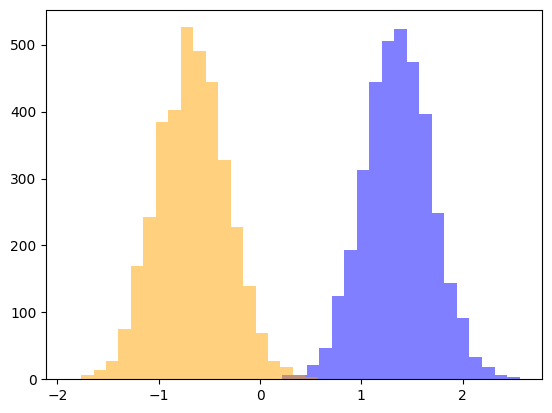

In [257]:
fig, ax = plt.subplots()

ax.hist(int1, alpha=.5, color="blue", bins=20)
# ax.axvline(int1.mean() + 0.809884, color="black", linestyle="--")
ax.hist(int2, alpha=.5, color="orange", bins=20)

In [246]:
int2.mean() - int1.mean()

tensor(-0.9835)

In [222]:
long_df.loc[:, "Condition"] = long_df["Run"].str.split("_", expand=True)[0]
long_df.loc[:, "Cell_line"] = long_df["Run"].str.split("_", expand=True)[1]

In [223]:
reg = smf.ols(formula="Abundance ~ C(Condition)", data=long_df[long_df["Protein"] == "CDKN1A"]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Abundance   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     159.6
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           1.16e-23
Time:                        13:28:37   Log-Likelihood:                -130.36
No. Observations:                 120   AIC:                             264.7
Df Residuals:                     118   BIC:                             270.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.0827      0.098     21.165      0.000       1.888       2.278
C(Condition)[T.DMSO]    -1.6762      0.133    -12.632      0.000      -1.939      -1.413
==============================================================================
Omnibus:                       12.068   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.562
Skew:                          -0.735   Prob(JB):                      0.00187
Kurtosis:                       3.592   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [254]:
reg = smf.ols(formula="Abundance ~ C(Condition)", data=long_df[long_df["Protein"] == "BCL2"]).fit()
reg.summary()

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Abundance   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     10.61
Date:                Tue, 10 Sep 2024   Prob (F-statistic):             0.0312
Time:                        13:50:07   Log-Likelihood:                 4.2409
No. Observations:                   6   AIC:                            -4.482
Df Residuals:                       4   BIC:                            -4.898
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.3761      0.084     28.156      0.000       2.142       2.610
C(Condition)[T.DMSO]     0.3887      0.119      3.257      0.031       0.057       0.720
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.015
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.002
Skew:                          -0.042   Prob(JB):                        0.999
Kurtosis:                       2.998   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

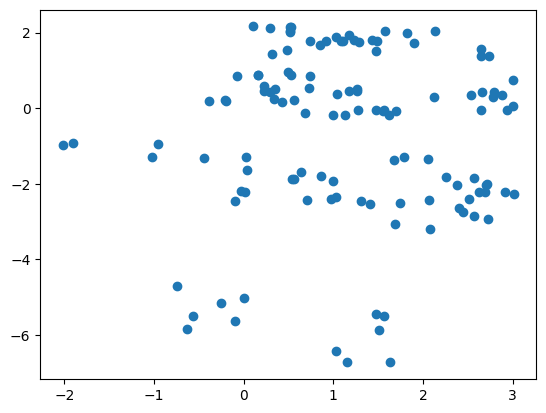

In [248]:
fig, ax = plt.subplots()

ax.scatter(input_data.loc[:, "CDKN1A"],
           input_data.loc[:, "NQO1"])

In [226]:
long_df.head()

,Protein,Run,Abundance,Condition,Cell_line
0,A1BG,Belinostat_A549_Rep1_norm2,3.061187,Belinostat,A549
1,A1BG,Belinostat_A549_Rep3_norm2,2.860346,Belinostat,A549
2,A1BG,Belinostat_H1915_Rep1_norm2,2.321107,Belinostat,H1915
3,A1BG,Belinostat_H1915_Rep2_norm2,2.285176,Belinostat,H1915
4,A1BG,Belinostat_H1915_Rep3_norm2,2.345030,Belinostat,H1915


In [227]:
test = long_df.pivot(index="Run", columns="Protein", values="Abundance")

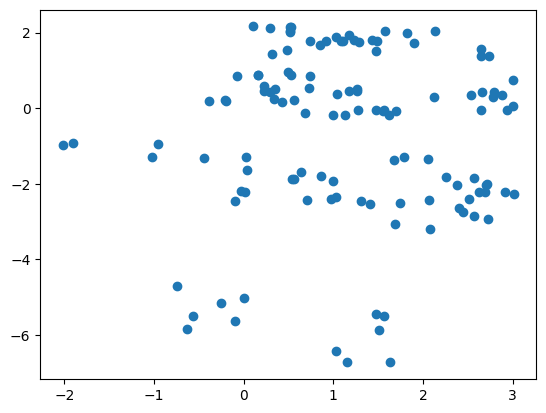

In [247]:
fig, ax = plt.subplots()

ax.scatter(test.loc[:, "CDKN1A"],
           test.loc[:, "NQO1"])